In [40]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [41]:
# Global Init Variables
GET_WEATHER = False

In [42]:
# read observations file that already has the PowderyMildew feature
observations_df = pd.read_csv('observations.csv')

# Drop rows with missing values
observations_df = observations_df.dropna()

observations_df.head()

,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6
1,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10
2,169576529,2023-06-26T09:10:01+02:00,"[8.80802725, 50.8119201389]",True,8.808027,50.811920,2023,6,26
3,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9
4,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19


In [43]:
# Function to parse date string and extract components
def extract_date_components(date_string):
    import datetime
    # Parse ISO format date string
    dt = datetime.datetime.fromisoformat(date_string.replace('Z', '+00:00'))
    return dt.year, dt.month, dt.day

# Extract relevant data for true observations
lons = []
lats = []
years = []
months = []
days = []

for _, row in observations_df.iterrows():
    # Parse the coordinates string into a list of floats
    coords = eval(row['coordinates'])
    lons.append(coords[0])
    lats.append(coords[1])
    
    # Extract the date components from the date_string
    year, month, day = extract_date_components(row['date_string'])
    years.append(year)
    months.append(month)
    days.append(day)
    
# Apply parsed data to the observations_df
observations_df['longitude'] = lons
observations_df['latitude'] = lats
observations_df['year'] = years
observations_df['month'] = months
observations_df['day'] = days

observations_df.head()


,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6
1,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10
2,169576529,2023-06-26T09:10:01+02:00,"[8.80802725, 50.8119201389]",True,8.808027,50.811920,2023,6,26
3,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9
4,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19


In [44]:
# Get NASA weather data at given coordinates 7 days before and after the given date
# 
# Parameters:
#   lon (float): Longitude coordinate
#   lat (float): Latitude coordinate
#   day (int): Day of the month
#   month (int): Month of the year
#   year (int): Year
#   param_list (list): List of weather parameters to retrieve
#
# Returns:
#   dict: Dictionary containing the requested weather parameters with their values,
#

def get_general_weather(lon, lat, day, month, year, param_list):
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    
    month_str = str(month).zfill(2)  # make sure is 2 length
    day_str = str(day).zfill(2)      # same as above
    start_date = f"{year}-{month_str}-{day_str}"

    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d") 
    end_date = start_date
    start_date -= datetime.timedelta(days=21)

    start_date = start_date.strftime("%Y%m%d")
    end_date = end_date.strftime("%Y%m%d")
    
    parameters = {
        "parameters": ",".join(param_list),
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }
    curr_data = {}

    response = requests.get(url, params=parameters)
    data = response.json()
    try:
        for param in param_list:
            curr_data[param] = data['properties']['parameter'][param]
    except:
        print(f"Error getting data for {year}-{month_str}-{day_str} at {lat},{lon}")
        return None
    
    return curr_data

In [45]:
# If GET_WEATHER is True, fetch weather data for each observation, save to weather_data.csv

if GET_WEATHER:
    """
    T2M	Temperature at 2 Meters
    RH2M	Relative Humidity at 2 Meters
    T2MDEW	Dew/Frost Point at 2 Meters
    PRECTOTCORR	Precipitation Corrected
    TSOIL1	Soil Temperatures Layer 1
    T2MWET	Wet Bulb Temperature at 2 Meters
    """
    data = []
    dataframe = pd.DataFrame(columns=['Datetime','id', 'Temperature', 'Humidity', 'Wind Speed', 'Dew/Frost Point', 'Wet Bulb Temperature', 'Specific Humidity'])

    param_list = ['T2M', 'RH2M', 'T2MDEW', 'PRECTOTCORR', 'TSOIL1', 'T2MWET']

    for i, row in observations_df.iterrows():
        weather_data = get_general_weather(row['longitude'], row['latitude'], row['day'], row['month'], row['year'], param_list)
        if weather_data is None:
            for j in range(3):
                weather_data = get_general_weather(row['longitude'], row['latitude'], row['day'], row['month'], row['year'], param_list)
                if weather_data is not None:
                    break
        if weather_data is None:    
            continue
        dates = list(weather_data['T2M'].keys())
        id_vals = [row['id']] * len(dates)
        temp_values = list(weather_data['T2M'].values())
        humidity_values = list(weather_data['RH2M'].values())
        dew_frost_values = list(weather_data['T2MDEW'].values())
        precipitation_values = list(weather_data['PRECTOTCORR'].values())
        soil_temperature_values = list(weather_data['TSOIL1'].values())
        wet_bulb_values = list(weather_data['T2MWET'].values())
        curr_df = pd.DataFrame({
            'Datetime': dates,
            'id': id_vals,
            'Temperature': temp_values,
            'Humidity': humidity_values,
            'Precipitation': precipitation_values,
            'Dew/Frost Point': dew_frost_values,
            'Wet Bulb Temperature': wet_bulb_values,
            'Soil Temperature': soil_temperature_values
        })
        
        weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'Dew/Frost Point', 'Wet Bulb Temperature', 'Soil Temperature']
        
        dataframe = pd.concat([dataframe, curr_df], ignore_index=True)
        # Print progress every 10 rows
        if i % 10 == 0:
            print(f"Processed {i}")
        
    dataframe.to_csv('weather_data.csv', index=False)

In [46]:
observations_df.head()

,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6
1,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10
2,169576529,2023-06-26T09:10:01+02:00,"[8.80802725, 50.8119201389]",True,8.808027,50.811920,2023,6,26
3,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9
4,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19


In [ ]:
# Load the weather data if not already loaded
from datetime import datetime, timedelta

# Load the weather data
weather_df = pd.read_csv('weather_data.csv')

# convert datetime to same format as observations_df
weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime'], format='%Y%m%d%H')
weather_df['Date'] = weather_df['Datetime'].dt.date

# Use same format as weather_df
observations_df['Date'] = pd.to_datetime(observations_df[['year', 'month', 'day']])

# Group by id and Date to find all unique days per ID
day_indices = weather_df.groupby(['id', 'Date']).first().reset_index()

# make dict of observation ID with original date
observation_dates = {}
for _, row in observations_df.iterrows():
    observation_dates[row['id']] = row['Date']

# Calculate difference between observation date and weather date
def get_relative_day(row):
    obs_date = observation_dates.get(row['id'])
    this_date = pd.to_datetime(row['Date'])
    difference = (this_date - obs_date).days
    return difference

# Apply the function to get relative day
day_indices['RelativeDay'] = day_indices.apply(get_relative_day, axis=1)

# Add relative day to weather_df
day_map = day_indices.set_index(['id', 'Date'])['RelativeDay']
weather_df['RelativeDay'] = weather_df.set_index(['id', 'Date']).index.map(day_map)

# Variables to calculate aggregations for
weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'Dew/Frost Point', 'Wet Bulb Temperature', 'Soil Temperature']

# Time windows to aggregate over (days before and after the observation day)
time_windows = {
    'day_of': (0, 0),
    'day_before_after': (-1, 0),
    'two_days': (-2, 0),
    'three_days': (-3, 0),
    'one_week': (-7, 0),
    'two_week': (-14, 0)
}

# Function to calculate aggregates given ID and time window
def calculate_aggregates(weather_subset, var_name, window_name, start_day, end_day):
    # Filter data for given time window
    window_data = weather_subset[(weather_subset['RelativeDay'] >= start_day) & (weather_subset['RelativeDay'] <= end_day)]
    
    # Calculate aggregate and return as a series
    result = pd.Series({
        f"{var_name}_{window_name}_mean": window_data[var_name].mean(),
        f"{var_name}_{window_name}_min": window_data[var_name].min(),
        f"{var_name}_{window_name}_max": window_data[var_name].max(),
        f"{var_name}_{window_name}_median": window_data[var_name].median()
    })
    
    return result

# Create empty DataFrame to store results
all_features = []
result_rows = []

# For each observation row, calculate all aggregate weather data
for id_val in observations_df['id'].unique():
    id_weather = weather_df[weather_df['id'] == id_val]
        
    # Dictionary to store aggregated values for this ID
    id_features = {'id': id_val}
    
    # Iterate over all weather data variables
    for var in weather_vars:
        # iterate over all items in time_windows
        for window_name, (start_day, end_day) in time_windows.items():
            aggs = calculate_aggregates(id_weather, var, window_name, start_day, end_day)
            id_features.update(aggs)
            
            # Add feature names to our list (only once)
            if id_val == observations_df['id'].unique()[0]:
                all_features.extend(aggs.index.tolist())
    
    result_rows.append(id_features)

# Create DataFrame from results
aggregated_features = pd.DataFrame(result_rows)

# Merge with the original observations dataframe
observations_df = observations_df.merge(aggregated_features, on='id', how='left')

# Create list of feature names
weather_feature_names = all_features

print(f"Created {len(weather_feature_names)}  features")

Created 120  features


In order to decrease relationships between variables (such as the connections and potential spurrious correlations between powdery mildew and date_string, month, and day) we can combine this date information into one number: the day of the calendar year 1-365.

In [48]:
# Calculate day of year from year, month, and day
from datetime import datetime

# Add day of year as a feature to observations_df
observations_df['day_of_year'] = observations_df.apply(
    lambda row: datetime(row['year'], row['month'], row['day']).timetuple().tm_yday, 
    axis=1
)

# Drop rows with NaN values
observations_df = observations_df.dropna()

# Display the updated DataFrame
observations_df.head()


,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day,Date,...,Wet Bulb Temperature_three_days_median,Wet Bulb Temperature_one_week_mean,Wet Bulb Temperature_one_week_min,Wet Bulb Temperature_one_week_max,Wet Bulb Temperature_one_week_median,Wet Bulb Temperature_two_week_mean,Wet Bulb Temperature_two_week_min,Wet Bulb Temperature_two_week_max,Wet Bulb Temperature_two_week_median,day_of_year
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6,2020-06-06,...,20.110,16.513073,5.80,24.15,17.295,16.141833,5.80,24.15,16.375,158
1,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10,2022-05-10,...,6.820,9.105469,2.02,15.95,9.140,8.083889,-0.63,15.95,8.610,130
2,169576529,2023-06-26T09:10:01+02:00,"[8.80802725, 50.8119201389]",True,8.808027,50.811920,2023,6,26,2023-06-26,...,16.545,17.749531,12.22,22.54,17.880,16.087667,8.54,22.54,16.250,177
3,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9,2024-04-09,...,8.930,8.505573,2.13,17.29,8.180,8.049167,0.80,17.29,8.105,100
4,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19,2023-05-19,...,8.745,9.214010,2.75,14.16,9.090,10.147500,2.75,17.19,10.030,139


Now we are ready to build a regression tree using this updated data frame!

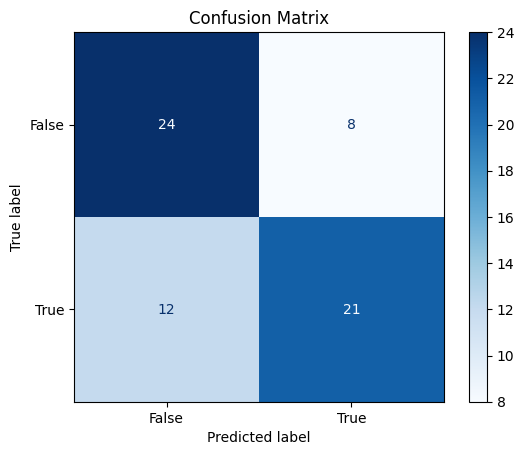


Accuracy: 0.6923076923076923
Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.75      0.71        32
        True       0.72      0.64      0.68        33

    accuracy                           0.69        65
   macro avg       0.70      0.69      0.69        65
weighted avg       0.70      0.69      0.69        65



In [49]:
# Define the features and target variable
features = weather_feature_names + ['day_of_year']
target = 'PowderyMildew'

X = observations_df[features]
y = observations_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Create and display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=[False, True])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy}")
print("Classification Report:")
print(report)


Sensitivity has improved to 72%

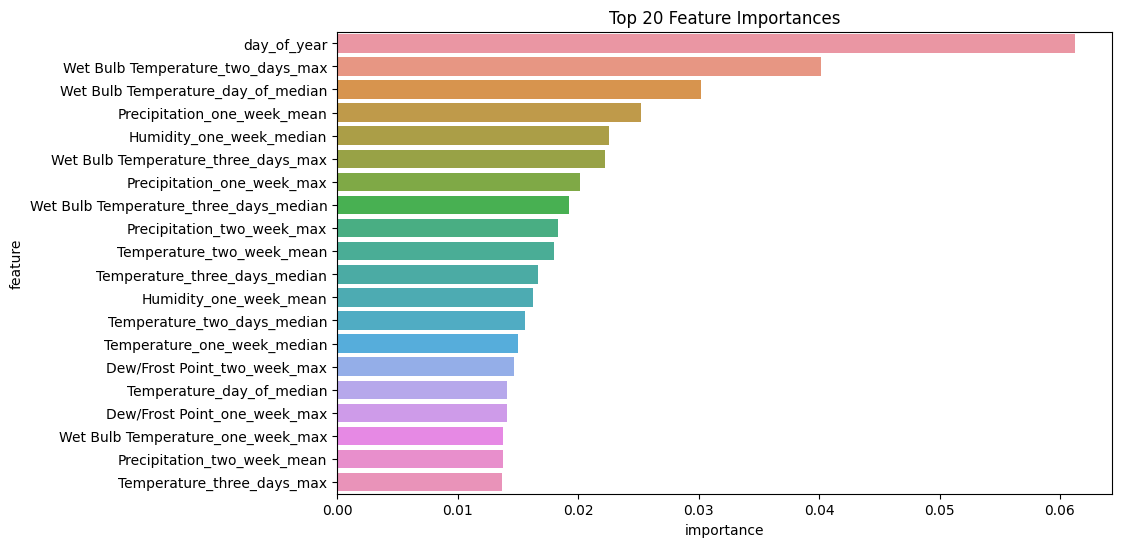

In [50]:
# Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Select top 20 features
top_20_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 Feature Importances')
plt.show()



Temperature and seasonality are very important.